In [1]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import date
from tqdm import tqdm

import matplotlib.pyplot as plt
import multiprocessing as mp

In [3]:
def update_stocks():
    os.system("rm mstcgl*.zip")
    os.system("rm mstcgl.zip -d data/")
    os.system("wget https://info.bossa.pl/pub/ciagle/mstock/mstcgl.zip")
    os.system("rm -rf data/*")
    os.system("unzip ms*.zip -d data/")
    
    print(f'Updated {date.today()}, max actual date: {prepare_data("WIG20").index.max()}')
    
def prepare_data(papier):
    
    if 'mst' in papier:
        df = pd.read_csv(f'data/{papier}')
    else:    
        df = pd.read_csv(f'data/{papier}.mst')
    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
    
    return df

In [4]:
update_stocks()

Updated 2020-04-01, max actual date: 2020-03-31 00:00:00


In [5]:
all_files = os.listdir('data/')
print(f'no of all available files: {len(all_files)}')

no of all available files: 1933


In [12]:
def plot_paper(papier, plot_range_min, plot_range_max):
    df = prepare_data(papier)

    plot_df = df.loc[(df.index >= plot_range_min) & 
                     (df.index <= plot_range_max),:].copy()
    if not plot_df.shape[0]:
        print('Nothing to show!')
        return 1
    spread = (plot_df.loc[:,'CLOSE'].max() - plot_df.loc[:,'CLOSE'].min()) / 14

    plot_df.loc[:,'CLOSE_diff'] = ((plot_df.loc[:,'CLOSE']
                                                - plot_df.loc[:,'CLOSE'].shift(1))
                                                / plot_df.loc[:,'CLOSE'].shift(1)) * 100

    plot_df_bar = ((plot_df.loc[:,'VOL'] - plot_df.loc[:,'VOL'].mean()) 
               / plot_df.loc[:,'VOL'].std() * spread)
    plot_df_bar = plot_df_bar + abs(plot_df_bar.min())
    plot_bar_bottom = plot_df.loc[:,'CLOSE'].min() - plot_df_bar.max()

    plot_df_vol_close = (plot_df.loc[:,'VOL'].rolling(3).mean() * 
             plot_df.loc[:,'CLOSE_diff'].rolling(3).mean())
    plot_df_vol_close = ((plot_df_vol_close - plot_df_vol_close.mean()) / plot_df_vol_close.std() ) * spread
    plot_df_vol_close = plot_df_vol_close + (plot_bar_bottom - plot_df_vol_close.max())
    
    bottom_date = plot_df.loc[plot_df.loc[:,'CLOSE'] == plot_df.loc[:,'CLOSE'].min()].index.strftime('')[0]


    plt.figure(figsize=(20,10))
    plt.plot(plot_df.loc[:,'CLOSE'])
    plt.plot(plot_df_vol_close)

    plt.bar(plot_df_bar.index, 
            plot_df_bar.values,
           bottom = plot_bar_bottom)

    plt.hlines(plot_df.loc[:,'CLOSE'].min(), 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='blue')
#     plt.hlines(plot_df.loc[plot_df.index >= bottom_date,'CLOSE'].max(), 
#                plot_range_min, plot_range_max, 
#                linestyles='--', 
#                colors='red')
    plt.hlines(plot_df.loc[:,'CLOSE'].min()*1.2, 
               plot_range_min, plot_range_max, 
               linestyles='--', 
               colors='red')
    plt.legend([df.TICKER[0],
                'volumen * close',
               'minimum',
               'maksimum',
               'volumen'])
    plt.show()

In [7]:
before_crises = '2020-02-15'
big_drop_date = '2020-03-12'
today = str(date.today())

watch = ['PZU', 'KGHM', 'ASSECOSEE', 
         'NORTCOAST', 'CDPROJEKT', 'VOTUM', 
         'NEWAG', 'KRUSZWICA', 'INTERAOLT', 
         'PLAY', 'ARCHICOM', 'LPP', 'ARCTIC', 'PGNIG',
        'TAURONPE', 'PKOBP', 'JSW']

watch_af = ['KGHM','KRUK', 'PKNORLEN','ENEA','MBANK', 'PKOBP', 'WIELTON']

[a for a in all_files if 'WIG20' in a]

['WIG20SHORT.mst', 'WIG20.mst', 'WIG20DVP.mst', 'WIG20TR.mst', 'WIG20LEV.mst']

In [14]:
papier = 'PLAY'

In [15]:
plot_paper(papier,'2008-07-15','2008-11-15')

Nothing to show!


1

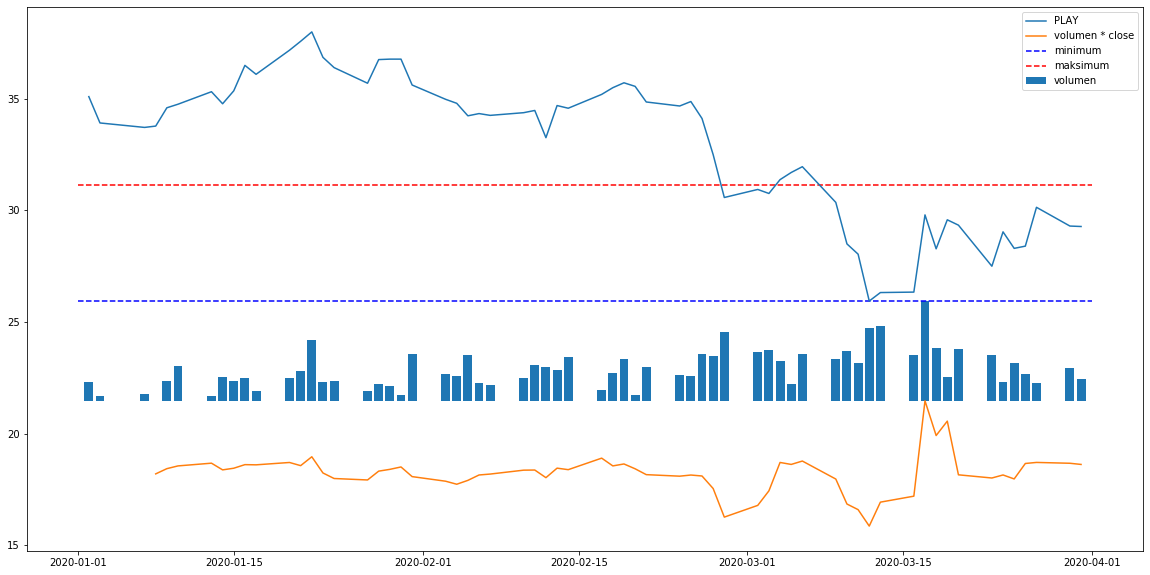

In [16]:
plot_paper(papier,'2020-01-01', str(date.today()))

In [23]:
df = prepare_data('KGHM')

In [30]:
papier = 'KGHM'

In [31]:
data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max = prepare_stats_forone(papier)

In [32]:
print(f'Max before crisis: {data_max_before_crisis}')
print(f'Crisis bottom: {data_crises_min}')
print(f'Max after crisis drop: {data_max_after_drop}')
print(f'Stats after Max: {data_min_after_max.values}')

Max before crisis: 101.0
Crisis bottom: 49.4
Max after crisis drop: 59.82
Stats after Max: [59.82]


In [26]:
def prepare_stats_forone(papier):
    df = prepare_data(papier)

    df = df.loc[df.index >= '2020-01-01',:]

    before_crises
    data_max_before_crisis = df.loc[(df.index <= before_crises) &
                                 (df.index >= '2020-01-01'),"CLOSE"].max()
    data_max_after_drop = df.loc[df.index >= big_drop_date,"CLOSE"].max()
    data_min_after_max = df.loc[df.index >= df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index[0], 'CLOSE']
    #data_min_after_max = df.loc[df.index >= (df.loc[df.loc[:,'CLOSE'] == data_max_after_drop].index), 'CLOSE']

    data_crises_min = df.loc[(df.index <= big_drop_date) & 
           (df.index >= before_crises),"CLOSE"].min()
    return data_max_before_crisis, data_crises_min, data_max_after_drop, data_min_after_max

## Skaner

In [123]:
before_crisis = '2020-02-17'
top_bottom = '2020-03-12'
new_year = '2020-01-01'
last_y_quarter = '2019-10-01'
last_y_mid = '2019-06-03'

df_cols = ['ticker', 'current', 'before_crisis', 'last_y_q', 'last_y_mid',
           'crisis_bottom', 
           'max_after_crisis', 'max_before_crisis']

### All papers

In [146]:
skaner_df = pd.DataFrame(columns=df_cols)
for w in tqdm(all_files):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_df = pd.concat([skaner_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 1918/1918 [00:11<00:00, 167.77it/s]


In [147]:
skaner_df.loc[:,'growth_quarter'] = round(skaner_df.loc[:,'before_crisis'] * 100 / skaner_df.loc[:,'last_y_q'] - 100, 2)
skaner_df.loc[:,'growth_mid'] = round(skaner_df.loc[:,'last_y_q'] * 100 / skaner_df.loc[:,'last_y_mid'] - 100, 2)
skaner_df.loc[:,'growth_from_crisis'] = round(skaner_df.loc[:,'max_after_crisis'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'growth_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_df.loc[:,'drop_current'] = round(skaner_df.loc[:,'current'] * 100 / skaner_df.loc[:,'max_before_crisis'] - 100, 2)

In [152]:
skaner_df_see = skaner_df.loc[(skaner_df.growth_quarter > 0) 
        & (skaner_df.growth_mid > 0) 
#         & (skaner_df.drop_current < -15) 
#         & (skaner_df.growth_current > 10)
                              ,:].sort_values('drop_current', ascending=True)

In [153]:
skaner_df_see

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,drop_current
0,INTLSLV22350,3.00,20.00,19.46,9.85,3.000,8.00,21.75,2.77,97.56,166.67,0.00,-86.21
0,RCFL4CDPRO,21.10,70.00,25.97,16.85,9.730,22.20,73.00,169.54,54.12,128.16,116.86,-71.10
0,RAINBOW,11.30,35.90,27.00,21.70,5.940,12.30,37.50,32.96,24.42,107.07,90.24,-69.87
0,ENTER,17.00,51.40,38.20,32.70,14.000,20.00,52.60,34.55,16.82,42.86,21.43,-67.68
0,AMREST,19.00,47.70,44.75,38.40,18.500,24.00,49.15,6.59,16.54,29.73,2.70,-61.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,RCFL3GOLD,56.10,49.91,43.84,31.04,41.010,59.15,50.00,13.85,41.24,44.23,36.80,12.20
0,INTLGLD23069,138.10,119.10,92.45,34.34,74.650,143.50,120.70,28.83,169.22,92.23,85.00,14.42
0,INTLGLD11726,203.60,174.90,142.00,86.90,133.000,203.60,174.90,23.17,63.41,53.08,53.08,16.41
0,WIG20SHORT,5050.24,3696.44,3633.11,3490.73,4996.080,5623.80,3826.33,1.74,4.08,12.56,1.08,31.99


### WIG

In [140]:
skaner_wig_df = pd.DataFrame(columns=df_cols)
for w in tqdm([a for a in all_files if 'WIG-' in a]):
    df = pd.read_csv(f'data/{w}')

    df.columns = [str(c).replace('<','') for c in df.columns]
    df.columns = [str(c).replace('>','') for c in df.columns]

    df.loc[:,'DTYYYYMMDD'] = pd.to_datetime(df.loc[:,'DTYYYYMMDD'], format='%Y%m%d')

    df = df.set_index('DTYYYYMMDD')
   
    skaner_wig_df = pd.concat([skaner_wig_df,
                       pd.DataFrame([[
                    df.TICKER[0],
                    df.loc[:,'CLOSE'].tail(1).values[0],
                    df.loc[df.index == before_crisis ,'CLOSE'].max(),
                    df.loc[df.index == last_y_quarter ,'CLOSE'].max(),
                           df.loc[df.index == last_y_mid,'CLOSE'].max(),
                    df.loc[(df.index >= top_bottom) & (df.index <= today),'CLOSE'].min(),
                    df.loc[df.index > top_bottom ,'CLOSE'].max(),
                    df.loc[(df.index >= last_y_quarter) & (df.index <= before_crisis),'CLOSE'].max()
                    
                       ]],
                                    columns=df_cols)], axis = 0)

100%|██████████| 18/18 [00:00<00:00, 114.01it/s]


In [142]:
skaner_wig_df.loc[:,'growth_quarter'] = round(skaner_wig_df.loc[:,'before_crisis'] * 100 / skaner_wig_df.loc[:,'last_y_q'] - 100, 2)
skaner_wig_df.loc[:,'growth_mid'] = round(skaner_wig_df.loc[:,'last_y_q'] * 100 / skaner_wig_df.loc[:,'last_y_mid'] - 100, 2)
skaner_wig_df.loc[:,'growth_from_crisis'] = round(skaner_wig_df.loc[:,'max_after_crisis'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'growth_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'crisis_bottom'] - 100, 2)
skaner_wig_df.loc[:,'drop_current'] = round(skaner_wig_df.loc[:,'current'] * 100 / skaner_wig_df.loc[:,'max_before_crisis'] - 100, 2)
skaner_wig_df_see = skaner_wig_df.loc[(skaner_wig_df.growth_quarter > 0) & 
         (skaner_wig_df.growth_mid > 0) & 
          (skaner_wig_df.drop_current < -15) &
          (skaner_wig_df.growth_current > 10),:].sort_values('drop_current', ascending=True)

In [145]:
skaner_wig_df.sort_values('drop_current')

,ticker,current,before_crisis,last_y_q,last_y_mid,crisis_bottom,max_after_crisis,max_before_crisis,growth_quarter,growth_mid,growth_from_crisis,growth_current,drop_current
0,WIG-ODZIEZ,2960.69,5278.52,5800.23,5334.38,2573.37,3049.29,5800.23,-8.99,8.73,18.49,15.05,-48.96
0,WIG-PALIWA,4084.82,5743.80,7249.48,7128.78,3287.44,4103.72,7981.41,-20.77,1.69,24.83,24.26,-48.82
0,WIG-LEKI,3199.21,4714.40,5409.86,5175.02,2461.49,3493.03,6142.64,-12.86,4.54,41.91,29.97,-47.92
0,WIG-ENERG,1207.53,1688.06,1947.82,2131.68,999.33,1264.54,2266.20,-13.34,-8.63,26.54,20.83,-46.72
0,WIG-BANKI,4179.67,6852.02,7073.65,7513.37,4005.48,4406.52,7327.60,-3.13,-5.85,10.01,4.35,-42.96
0,WIG-GORNIC,1867.14,3032.56,2563.99,3432.77,1567.96,1903.04,3258.17,18.28,-25.31,21.37,19.08,-42.69
0,WIG-MOTO,2366.65,3855.75,3401.99,3659.14,2297.59,2649.82,3954.78,13.34,-7.03,15.33,3.01,-40.16
0,WIG-CHEMIA,5850.85,8099.24,8417.57,10545.21,4969.56,6067.49,9124.29,-3.78,-20.18,22.09,17.73,-35.88
0,WIG-MEDIA,4147.55,6380.04,5184.49,4934.25,3777.03,4432.30,6445.42,23.06,5.07,17.35,9.81,-35.65
0,WIG-ESG,6953.63,9983.76,9797.23,NaN,6337.72,7020.67,10251.60,1.90,NaN,10.78,9.72,-32.17


## Other

### Reports

In [42]:
all_reports = pd.read_csv('../bizcrap/fundamental_reports.csv')

In [61]:
cols_to_change = list(all_reports.columns)
cols_to_change[0] = 'Data'
all_reports.columns = cols_to_change

In [45]:
[a for a in all_reports.name.unique() if 'ORLEN' in a]

['raporty-PKN-ORLEN,Q.html']

In [55]:
cols_zysk = [c for c in all_reports.columns if 'zysk' in c]

In [53]:
for c in all_reports.columns:
    all_reports.loc[all_reports.loc[:,c]==-1,c] = np.nan

In [62]:
all_reports.head()

,Data,name,przychody_ze_sprzedaży_main,przychody_ze_sprzedaży_kk,przychody_ze_sprzedaży_sector,techniczny_koszt_wytworzenia_produkcji_sprzedanej_main,techniczny_koszt_wytworzenia_produkcji_sprzedanej_kk,techniczny_koszt_wytworzenia_produkcji_sprzedanej_sector,koszty_sprzedaży_main,koszty_sprzedaży_kk,...,odpisy_netto_z_tytułu_utraty_wartości_kredytów_sector,ogólne_koszty_administracyjne_main,ogólne_koszty_administracyjne_kk,ogólne_koszty_administracyjne_sector,wynik_operacyjny_main,wynik_operacyjny_kk,wynik_operacyjny_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
0,2011/Q1,"raporty-ROKITA,Q.html",282089.0,NaN,NaN,236690.0,NaN,NaN,16740.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011/Q2,"raporty-ROKITA,Q.html",120180.0,-57.40,-6.11,104329.0,-55.92,-7.29,7965.0,-52.42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011/Q3,"raporty-ROKITA,Q.html",186398.0,55.10,11.93,163713.0,56.92,4.74,10028.0,25.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011/Q4,"raporty-ROKITA,Q.html",232250.0,24.60,24.60,184412.0,12.64,12.64,17560.0,75.11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2012/Q1,"raporty-ROKITA,Q.html",243002.0,4.63,-7.39,202362.0,9.73,-4.46,13294.0,-24.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
all_reports.loc[all_reports.name=='raporty-PKN-ORLEN,Q.html',['Data', 'name'] + cols_zysk]

,Data,name,zysk_ze_sprzedaży_main,zysk_ze_sprzedaży_kk,zysk_ze_sprzedaży_sector,zysk_operacyjny_(ebit)_main,zysk_operacyjny_(ebit)_kk,zysk_operacyjny_(ebit)_sector,zysk_z_działalności_gospodarczej_main,zysk_z_działalności_gospodarczej_kk,...,zysk_(strata)_netto_z_działalności_zaniechanej_sector,zysk_netto_main,zysk_netto_kk,zysk_netto_sector,zysk_netto_akcjonariuszy_jednostki_dominującej_main,zysk_netto_akcjonariuszy_jednostki_dominującej_kk,zysk_netto_akcjonariuszy_jednostki_dominującej_sector,udział_w_zyskach_jednostek_podporządkowanych_main,udział_w_zyskach_jednostek_podporządkowanych_kk,udział_w_zyskach_jednostek_podporządkowanych_sector
6856,2005/Q1,"raporty-PKN-ORLEN,Q.html",783503.0,NaN,NaN,797953.0,NaN,NaN,820771.0,NaN,...,NaN,678534.0,NaN,NaN,667527.0,NaN,NaN,NaN,NaN,NaN
6857,2005/Q2,"raporty-PKN-ORLEN,Q.html",1101747.0,40.62,11.69,2615077.0,227.72,9.19,2813959.0,242.84,...,NaN,2565468.0,278.09,38.03,2560212.0,283.54,28.11,NaN,NaN,NaN
6858,2005/Q3,"raporty-PKN-ORLEN,Q.html",1120514.0,1.70,37.29,1090777.0,-58.29,29.90,1221227.0,-56.60,...,NaN,994419.0,-61.24,-0.90,985238.0,-61.52,-0.04,NaN,NaN,NaN
6859,2005/Q4,"raporty-PKN-ORLEN,Q.html",673032.0,-39.94,-24.82,443813.0,-59.31,-34.51,417113.0,-65.84,...,NaN,399355.0,-59.84,-1.46,365479.0,-62.90,-3.24,NaN,NaN,NaN
6860,2006/Q1,"raporty-PKN-ORLEN,Q.html",411141.0,-38.91,33.42,450747.0,1.56,39.40,476236.0,14.17,...,NaN,398153.0,-0.30,49.27,364977.0,-0.14,52.20,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,2019/Q1,"raporty-PKN-ORLEN,Q.html",968000.0,86.15,52.80,996000.0,-2.73,31.91,994000.0,2.16,...,NaN,849000.0,37.16,37.16,849000.0,28.25,28.25,NaN,NaN,NaN
6913,2019/Q2,"raporty-PKN-ORLEN,Q.html",1964000.0,102.89,20.46,2086000.0,109.44,52.52,2124000.0,113.68,...,NaN,1601000.0,88.57,62.23,1602000.0,88.69,56.36,NaN,NaN,NaN
6914,2019/Q3,"raporty-PKN-ORLEN,Q.html",1975000.0,0.56,1.69,1807000.0,-13.37,-13.37,1567000.0,-26.22,...,NaN,1266000.0,-20.92,-20.92,1266000.0,-20.97,-23.19,NaN,NaN,NaN
6915,2019/Q4,"raporty-PKN-ORLEN,Q.html",919000.0,-53.47,-16.94,673000.0,-62.76,-32.94,866000.0,-44.74,...,NaN,771000.0,-39.10,-19.55,772000.0,-39.02,-21.16,NaN,NaN,NaN
